<h2> <span style="color: Red;"> Amr Rashad | Social Network Analysis Project | English Twitch dataset </span> </h2>

## <span style="color: LightBlue;"> 0. Outline </span>

1. Loading the dataset and creating the Twitch network graph
2. Perform network analysis
    - Degree Analysis
    - Network Density
    - Average shortest path
    - ECDF & ECCDF
    - Determining the network's hubs
    - Calculating the transitivity
    - Calculating the clustering coefficient
    - Calculating the centrality of each node in the entire network
3. Perform community detection
    - Calculating the modularity using the greedy approach
    - Calculating the modularity using the Louvain approach
    - Evaluating the communities
    - Determining the distribution size of the communities
    - Calculating the centrality of each node in its own community

## <span style="color: IndianRed;"> 1. Loading The Dataset & Exploratory Data Analysis </span>

### <span style="color: LightSalmon;"> *1.1 Load Required Libraries:* </span>

In [113]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import networkx.algorithms.community as nx_comm
from infomap import Infomap
from collections import defaultdict
from operator import itemgetter
from networkx.algorithms import community

### <span style="color: LightSalmon;"> *1.2 Loading The Dataset & Creating Our Graph:* </span>

In [114]:
Twitch_nodes = pd.read_csv('EN_target.csv')
Twitch_nodes.head()

,ID,Days,Mature,Views,Partner,New_ID
0,73045350,1459,False,9528,False,2299
1,61573865,1629,True,3615,False,153
2,171688860,411,True,46546,False,397
3,117338954,953,True,5863,False,5623
4,135804217,741,True,5594,False,5875


In [115]:
Twitch_edges = pd.read_csv('EN_edges.csv')
Twitch_edges.head()

,from,to
0,6194,255
1,6194,980
2,6194,2992
3,6194,2507
4,6194,986


In [116]:
Twitch_nodes.dtypes

ID         int64
Days       int64
Mature      bool
Views      int64
Partner     bool
New_ID     int64
dtype: object

In [117]:
#Let's change the categorical variables into numerical ones
Twitch_nodes['Mature'] = np.multiply(Twitch_nodes['Mature'], 1)
Twitch_nodes['Partner'] = np.multiply(Twitch_nodes['Mature'], 1)
Twitch_nodes.head()

,ID,Days,Mature,Views,Partner,New_ID
0,73045350,1459,0,9528,0,2299
1,61573865,1629,1,3615,1,153
2,171688860,411,1,46546,1,397
3,117338954,953,1,5863,1,5623
4,135804217,741,1,5594,1,5875


In [118]:
# Creating an empty graph
Twitch_graph=nx.Graph()

In [119]:
#Adding nodes & edges
Twitch_graph.add_nodes_from(Twitch_nodes['New_ID'])
Twitch_graph.add_edges_from(zip(Twitch_edges['from'], Twitch_edges['to']))

In [120]:
#Setting node attributes
nx.set_node_attributes(Twitch_graph, Twitch_nodes['Days'], 'Days')
nx.set_node_attributes(Twitch_graph, Twitch_nodes['Mature'], 'Mature')
nx.set_node_attributes(Twitch_graph, Twitch_nodes['Views'], 'Views')
nx.set_node_attributes(Twitch_graph, Twitch_nodes['Partner'], 'Partner')

In [121]:
print(Twitch_graph)

Graph with 7126 nodes and 35324 edges


In [123]:
# list_nodes=list(Twitch_graph.nodes)
# list_edges=list(Twitch_graph.edges)

## <span style="color: IndianRed;"> 2. Network Analysis </span>

### <span style="color: LightSalmon;"> *2.1 Degree Analysis:* </span>

In [126]:
#Applying the degree method to understand how many degrees we have for each node
degree = Twitch_graph.degree
Twitch_graph_degree_dict = dict(Twitch_graph.degree)
Twitch_graph_degree_list = list(dict(Twitch_graph.degree()).values())
print(np.mean(Twitch_graph_degree_list))
print(np.median(Twitch_graph_degree_list))
print(np.std(Twitch_graph_degree_list))
print(np.max(Twitch_graph_degree_list))
print(np.min(Twitch_graph_degree_list))

9.914117316867808
5.0
22.18870615557688
720
1


In [127]:
Twitch_degree_view=Twitch_graph.degree()
print(type(Twitch_degree_view))
print(Twitch_degree_view)
Twitch_degree=list(dict(Twitch_graph.degree()).values())
print('\n',type(Twitch_degree))
print(Twitch_degree)

### <span style="color: LightSalmon;"> *2.2 Network Density:* </span>

In [128]:
density = nx.density(Twitch_graph)
print('Network Density: ', density)

Network Density:  0.0013914550620165345


### <span style="color: LightSalmon;"> *2.3 Average Shortest Path:* </span>

In [129]:
average_shortest_path = nx.average_shortest_path_length(Twitch_graph)

In [130]:
print('Average shortest path: ', average_shortest_path)

Average shortest path:  3.6776157289097005


### <span style="color: LightSalmon;"> *2.4 ECDF & ECCDF:* </span>

- Because we have a large network, it's best to use the loglog scale

Text(0, 0.5, 'ECCDF')

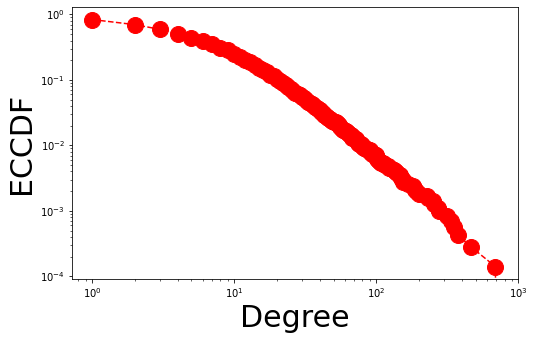

In [131]:
cdf_function = ECDF(Twitch_degree)
x = np.unique(Twitch_degree)
# ECCDF in loglog scale
y = 1-cdf_function(x)
fig_ccdf_function = plt.figure(figsize=(8,5))
axes = fig_ccdf_function.gca()
axes.loglog(x,y,color = 'red', linestyle = '--', marker= 'o',ms = 16)
axes.set_xlabel('Degree',size = 30)
axes.set_ylabel('ECCDF',size = 30)


### <span style="color: LightSalmon;"> *2.5 Determining The Hubs:* </span>

- To determine the hubs of the network, we will be using the ECCDF in loglog scale

In [132]:
percentile_95 = np.percentile(Twitch_degree,95)
print(percentile_95)

32.0


- Identifying the list of hubs in our Twitch network

In [133]:
hub_nodi = [k for k,v in dict(Twitch_graph.degree()).items() if v>= percentile_95]
print(hub_nodi)

### <span style="color: LightSalmon;"> *2.6 Triangles & Transitivity:* </span>

In [134]:
print('Twitch graph - dictionary keyed by nodes: number of triangles {}'.format(nx.triangles(Twitch_graph)))

In [135]:
print('Twitch graph - list of the number of triangles of all nodes: {}'.format(list(nx.triangles(Twitch_graph).values())))

In [136]:
print('Twitch graph - transitivity: {}'.format(nx.transitivity(Twitch_graph)))

Twitch graph - transitivity: 0.04243324947984254


### <span style="color: LightSalmon;"> *2.7 Clustering Coefficient:* </span>

In [137]:
print('Twitch graph - local clustering: {}'.format(nx.clustering(Twitch_graph)))

Twitch graph - local clustering: {2299: 0.14285714285714285, 153: 0.0935672514619883, 397: 0.05555555555555555, 5623: 0, 5875: 0, 3346: 0, 6930: 0.15384615384615385, 6367: 0.3333333333333333, 1434: 0.16666666666666666, 4470: 0.3333333333333333, 5122: 0.05853174603174603, 4790: 0.6, 4919: 0.06666666666666667, 575: 1.0, 639: 0.17857142857142858, 7012: 0.027777777777777776, 6445: 0, 1170: 0.09881422924901186, 326: 0, 4956: 0, 2639: 0.1282051282051282, 5028: 0, 6277: 0.2, 6784: 0.5, 49: 0.3, 4526: 0, 4108: 0, 1171: 0, 2568: 0, 5731: 0.16025641025641027, 1760: 0, 6707: 0, 2019: 0.2523809523809524, 634: 0, 4670: 0, 2399: 0.0989010989010989, 5737: 0, 6974: 0.053763440860215055, 6919: 0, 240: 0.3333333333333333, 5646: 0, 158: 0.16666666666666666, 3298: 0.25, 2354: 0.12535612535612536, 1161: 0, 1869: 0.04295366795366795, 3499: 0.05714285714285714, 5655: 0.3333333333333333, 5295: 0, 6468: 0, 3872: 1.0, 5676: 0.022222222222222223, 72: 0, 544: 1.0, 4228: 0, 2430: 0.16666666666666666, 2677: 0.15555

In [138]:
#Average Local Clustering:
nx.average_clustering(Twitch_graph), np.mean(list(nx.clustering(Twitch_graph).values()))

(0.13092821901472038, 0.1309282190147198)

In [139]:
np.median(list(nx.triangles(Twitch_graph).values()))

1.0

### <span style="color: LightSalmon;"> *2.8 Centrality:* </span>

In [140]:
sorted_degree = sorted(Twitch_graph_degree_dict.items(), key = itemgetter(1), reverse= True)
print('Top 10 nodes by degree:')
for i in sorted_degree[:10]:
    print(i)

Top 10 nodes by degree:
(1773, 720)
(4949, 691)
(3401, 465)
(6136, 378)
(166, 352)
(5842, 336)
(1924, 316)
(2732, 278)
(2447, 272)
(1103, 254)


In [141]:
betweeness_dict = nx.betweenness_centrality(Twitch_graph)
#Adding the values of the centralities as attributes in the network's nodes
nx.set_node_attributes(Twitch_graph, betweeness_dict, 'betweeness')


In [142]:
eigenvector_dict = nx.eigenvector_centrality(Twitch_graph)
nx.set_node_attributes(Twitch_graph, eigenvector_dict, 'eigenvector')

In [143]:
sorted_betweeness = sorted(betweeness_dict.items(), key= itemgetter(1), reverse= True)
print('Top 10 nodes by betweeness centrality: ')
for i in sorted_betweeness[:10]:
    print(i)

Top 10 nodes by betweeness centrality: 
(1773, 0.1267671290373342)
(4949, 0.11817297351037323)
(3401, 0.06731818713363985)
(5842, 0.046398599727166014)
(6136, 0.0373696822989486)
(1924, 0.037065818453528986)
(166, 0.03671649359635466)
(2447, 0.03320420573262955)
(2732, 0.02502442500290993)
(581, 0.02450598203267532)


## <span style="color: IndianRed;"> 3. Community Detection </span>

### <span style="color: LightSalmon;"> *3.1 Modularity Maximization - Greedy Algorithm:* </span>

In [144]:
list_community_sets_greedy = list(nx_comm.greedy_modularity_communities(Twitch_graph))
print(list_community_sets_greedy)

In [145]:
partition_greedy = {}
for i, comm in enumerate(list_community_sets_greedy):
    print('Community:', i)
    print(i, comm) #printing the list of nodes that belong to each community
    for n in comm:
        partition_greedy[n] = i

Community: 0
0 frozenset({1, 4, 5, 9, 22, 29, 31, 32, 34, 37, 38, 41, 44, 45, 46, 57, 58, 61, 62, 64, 66, 69, 75, 76, 81, 85, 87, 88, 93, 94, 95, 99, 104, 105, 117, 119, 124, 125, 127, 128, 131, 135, 136, 137, 139, 145, 147, 152, 153, 154, 159, 161, 164, 168, 170, 172, 174, 175, 179, 187, 189, 191, 192, 195, 199, 202, 203, 205, 208, 210, 212, 221, 222, 226, 229, 234, 244, 245, 246, 250, 251, 252, 259, 262, 263, 264, 265, 266, 269, 270, 271, 272, 274, 276, 278, 279, 285, 290, 292, 296, 301, 302, 314, 317, 323, 325, 326, 327, 328, 329, 332, 333, 334, 348, 349, 355, 357, 358, 368, 369, 376, 383, 384, 387, 388, 389, 392, 399, 400, 401, 404, 408, 417, 422, 425, 428, 429, 435, 438, 442, 443, 446, 450, 457, 461, 462, 466, 473, 475, 483, 486, 490, 493, 496, 498, 499, 501, 502, 509, 513, 514, 517, 523, 524, 525, 529, 530, 533, 534, 539, 540, 542, 544, 545, 546, 550, 552, 563, 564, 568, 575, 579, 581, 587, 588, 596, 599, 601, 602, 605, 610, 613, 617, 618, 638, 639, 641, 646, 649, 651, 652, 658, 

In [146]:
#print(partition_greedy) #printing each node with the community that it belongs to in a dictionary format

In [147]:
nx.set_node_attributes(Twitch_graph, partition_greedy, 'Twitch_comm_greedy')

### <span style="color: LightSalmon;"> *3.2 Modularity Maximization - Louvain Algorithm:* </span>

In [148]:
partition_library = community_louvain.best_partition(Twitch_graph)
print(partition_library)

{2299: 0, 153: 1, 397: 2, 5623: 2, 5875: 3, 3346: 4, 6930: 0, 6367: 5, 1434: 2, 4470: 6, 5122: 11, 4790: 8, 4919: 8, 575: 9, 639: 3, 7012: 0, 6445: 9, 1170: 2, 326: 5, 4956: 8, 2639: 2, 5028: 10, 6277: 7, 6784: 2, 49: 2, 4526: 5, 4108: 10, 1171: 5, 2568: 5, 5731: 3, 1760: 6, 6707: 0, 2019: 3, 634: 8, 4670: 9, 2399: 5, 5737: 8, 6974: 6, 6919: 2, 240: 8, 5646: 5, 158: 5, 3298: 2, 2354: 8, 1161: 2, 1869: 8, 3499: 2, 5655: 7, 5295: 6, 6468: 5, 3872: 0, 5676: 5, 72: 6, 544: 0, 4228: 9, 2430: 2, 2677: 5, 576: 11, 5986: 5, 3707: 8, 809: 10, 593: 2, 2456: 6, 6911: 10, 3362: 8, 7101: 11, 7060: 9, 6080: 3, 5771: 3, 5914: 11, 6794: 6, 3361: 8, 3260: 0, 936: 6, 3837: 12, 2233: 3, 4568: 8, 3468: 5, 5540: 2, 6304: 9, 3284: 9, 1376: 10, 4702: 8, 6480: 8, 5021: 2, 6756: 3, 2533: 8, 6062: 6, 5956: 0, 5768: 3, 1636: 9, 1524: 13, 1385: 3, 119: 10, 3213: 5, 4487: 10, 839: 5, 6165: 5, 1150: 9, 701: 2, 1794: 4, 3998: 0, 4923: 3, 542: 6, 7074: 11, 4315: 6, 1481: 8, 5915: 9, 948: 2, 799: 2, 6513: 2, 413: 9, 3

In [149]:
nx.set_node_attributes(Twitch_graph, partition_library, 'community_library')

### <span style="color: LightSalmon;"> *3.3 Evaluating The Communities:* </span>

In [150]:
Twitch_communities = set(partition_library.values())
Twitch_communities

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [151]:
list_community_sets_louvain = [set() for i in range(len(Twitch_communities))]

In [152]:
for n, Twitch_communities in partition_library.items():
    list_community_sets_louvain[Twitch_communities].add(n)

list_community_sets_louvain

[{10,
  12,
  19,
  27,
  39,
  87,
  88,
  99,
  105,
  106,
  136,
  143,
  152,
  155,
  164,
  170,
  175,
  188,
  194,
  203,
  212,
  222,
  228,
  229,
  260,
  264,
  281,
  292,
  293,
  296,
  323,
  328,
  346,
  350,
  364,
  365,
  376,
  429,
  440,
  471,
  478,
  482,
  483,
  490,
  497,
  501,
  540,
  544,
  558,
  571,
  580,
  583,
  588,
  601,
  602,
  605,
  618,
  626,
  633,
  646,
  649,
  661,
  687,
  697,
  706,
  708,
  713,
  715,
  717,
  720,
  731,
  742,
  744,
  755,
  768,
  769,
  773,
  781,
  782,
  795,
  806,
  807,
  815,
  821,
  840,
  842,
  850,
  872,
  904,
  917,
  953,
  974,
  1000,
  1014,
  1018,
  1021,
  1031,
  1032,
  1040,
  1044,
  1065,
  1071,
  1074,
  1106,
  1123,
  1125,
  1138,
  1151,
  1159,
  1188,
  1229,
  1239,
  1241,
  1243,
  1248,
  1255,
  1285,
  1303,
  1342,
  1346,
  1374,
  1382,
  1396,
  1398,
  1401,
  1410,
  1423,
  1488,
  1499,
  1506,
  1508,
  1512,
  1516,
  1530,
  1531,
  1546,
  1548,
  15

In [153]:
for my_list in [list_community_sets_greedy, list_community_sets_louvain]:
    #Coverage
    print('Coverage: ', nx_comm.coverage(Twitch_graph, my_list))
    #Modularity
    print('Modularity: ', nx_comm.modularity(Twitch_graph, my_list, weight= 'weight'))
    #Performance
    print('Performance: ', nx_comm.performance(Twitch_graph, my_list))

    print('---')

### <span style="color: LightSalmon;"> *3.4 Distribution Size Of The Communities:* </span>

In [154]:
pairs = []
for i, nodes in enumerate(list_community_sets_louvain):
    print(i, len(nodes))
    comm_size = (i, len(nodes))
    pairs.append(comm_size)

0 578
1 51
2 749
3 753
4 126
5 880
6 671
7 194
8 960
9 1035
10 476
11 331
12 212
13 88
14 8
15 14


In [155]:
community_index = []
number_of_nodes = []

for Twitch_communities, n_nodes in pairs:
    community_index.append(str(Twitch_communities))
    number_of_nodes.append(n_nodes)

Text(0, 0.5, 'Number of Nodes')

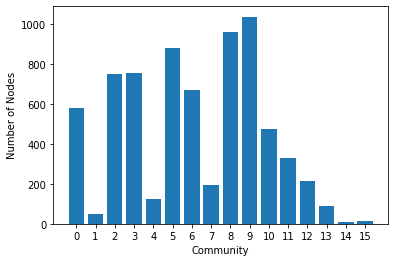

In [156]:
plt.bar(community_index, number_of_nodes)
plt.xlabel('Community')
plt.ylabel('Number of Nodes')

### <span style="color: LightSalmon;"> *3.5 Centrality in Communities:* </span>

In [157]:
centr_comm = {}
for comm in list_community_sets_louvain:
    subgraph = Twitch_graph.subgraph(comm)
    print(subgraph.order())
    print(nx.degree_centrality(subgraph))
    print('---')

578
{6146: 0.0034662045060658577, 2053: 0.0017331022530329288, 6149: 0.0017331022530329288, 4104: 0.0034662045060658577, 10: 0.0017331022530329288, 4107: 0.0017331022530329288, 12: 0.0034662045060658577, 6161: 0.0017331022530329288, 6163: 0.0017331022530329288, 19: 0.012131715771230503, 27: 0.0017331022530329288, 39: 0.0034662045060658577, 6185: 0.005199306759098786, 2090: 0.006932409012131715, 2094: 0.0017331022530329288, 2099: 0.0034662045060658577, 2105: 0.0017331022530329288, 6203: 0.008665511265164644, 2109: 0.0017331022530329288, 4157: 0.0017331022530329288, 4160: 0.0034662045060658577, 4162: 0.005199306759098786, 4165: 0.005199306759098786, 4168: 0.005199306759098786, 4169: 0.0017331022530329288, 4175: 0.0017331022530329288, 4181: 0.008665511265164644, 2135: 0.0017331022530329288, 87: 0.0017331022530329288, 2137: 0.0017331022530329288, 88: 0.0017331022530329288, 4191: 0.04506065857885615, 6241: 0.005199306759098786, 99: 0.012131715771230503, 4195: 0.0034662045060658577, 6248: 0.

In [158]:
centr_comm = {}
for comm in list_community_sets_louvain:
    subgraph = Twitch_graph.subgraph(comm)
    node_degrees = nx.degree_centrality(subgraph)
    for n, d in node_degrees.items():
        centr_comm[n] = d

In [159]:
#printing the degree centrality of each node in its community
centr_comm

{6146: 0.0034662045060658577,
 2053: 0.0017331022530329288,
 6149: 0.0017331022530329288,
 4104: 0.0034662045060658577,
 10: 0.0017331022530329288,
 4107: 0.0017331022530329288,
 12: 0.0034662045060658577,
 6161: 0.0017331022530329288,
 6163: 0.0017331022530329288,
 19: 0.012131715771230503,
 27: 0.0017331022530329288,
 39: 0.0034662045060658577,
 6185: 0.005199306759098786,
 2090: 0.006932409012131715,
 2094: 0.0017331022530329288,
 2099: 0.0034662045060658577,
 2105: 0.0017331022530329288,
 6203: 0.008665511265164644,
 2109: 0.0017331022530329288,
 4157: 0.0017331022530329288,
 4160: 0.0034662045060658577,
 4162: 0.005199306759098786,
 4165: 0.005199306759098786,
 4168: 0.005199306759098786,
 4169: 0.0017331022530329288,
 4175: 0.0017331022530329288,
 4181: 0.008665511265164644,
 2135: 0.0017331022530329288,
 87: 0.0017331022530329288,
 2137: 0.0017331022530329288,
 88: 0.0017331022530329288,
 4191: 0.04506065857885615,
 6241: 0.005199306759098786,
 99: 0.012131715771230503,
 4195: 0

In [160]:
nx.set_node_attributes(Twitch_graph, centr_comm, 'centr_comm')

In [161]:
sorted_centr_comm = sorted(centr_comm.items(), key= itemgetter(1), reverse= True)
print('Top 10 nodes by betweeness centrality: ')
for i in sorted_centr_comm[:10]:
    print(i)

Top 10 nodes by betweeness centrality: 
(1727, 0.7142857142857142)
(1773, 0.4072790294627383)
(4949, 0.3577127659574468)
(166, 0.32195676905574516)
(6531, 0.3076923076923077)
(5840, 0.3076923076923077)
(6619, 0.3076923076923077)
(1825, 0.2857142857142857)
(3843, 0.2857142857142857)
(5046, 0.28)


## <span style="color: IndianRed;"> 4. Creating A Gephi File For Network Visualization </span>

In [163]:
nx.write_gexf(G = Twitch_graph, path = 'EN.gexf')